## Imports

In [67]:
import leafmap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.plot import show
from affine import Affine
import numpy as np
import json
from shapely import wkt
import pandas as pd
import os
import tomllib
from pathlib import Path
import pickle
MAIN_CSV_PATH = "xBD_WUI_Analysis.csv"
CONFIG_FILE_PATH = "config.toml"

In [39]:
# --- CLASS MAP (code -> name) ---
CLASS_MAP = {
    1: "Residential: Large buildings and homes",
    2: "Residential: Small outbuildings",
    3: "Residential: Informal settlement",
    4: "Residential: Cars",
    5: "Residential: Miscellaneous",
    6: "Vegetative: Trees",
    7: "Vegetative: Shrubs and bushes",
    8: "Vegetative: Grass/lawns/low fuel",
    9: "Vegetative: Dried shrubs",
    10: "Vegetative: Dried grass",
    11: "Non-combustible: Roads/pavements",
    12: "Non-combustible: Bare soil",
    13: "Non-combustible: Water body",
    14: "Non-combustible: Undeveloped/concrete/bare",
    15: "Non-combustible: Destroyed structure",
    16: "Non-combustible: Burnt vegetation",
    17: "Unclassified",
}

In [40]:
import matplotlib.pyplot as plt
%matplotlib widget

In [61]:
import matplotlib.pyplot as plt
plt.close('all')          # closes all live figures
%matplotlib inline       

## Data Loading

In [8]:
with open(CONFIG_FILE_PATH, "rb") as f:
    data_config = tomllib.load(f)
data_config = data_config["datapaths"]

In [ ]:
analysis_df = pd.read_csv(MAIN_CSV_PATH)
analysis_df

In [143]:
scene_id = "pinery_0428"
scene_info = analysis_df[analysis_df["scene_id"] == scene_id].iloc[0]
scene_polygon_path = scene_info["polygon_path"]

In [144]:
with open(f"{data_config["data_root"]}{data_config["xBD_analysed_path"]}{scene_polygon_path}", 'rb') as f:
    scene_analysis_dict = pickle.load(f)

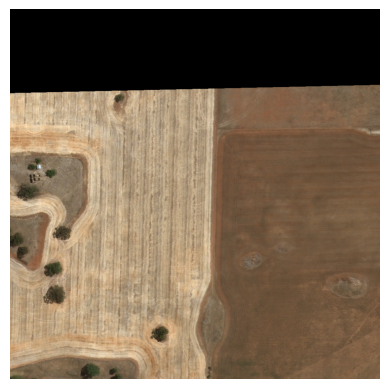

In [145]:
scene_norm_img = scene_analysis_dict.norm_image.iloc[0]
plt.imshow(scene_norm_img)
plt.axis('off')
plt.show()

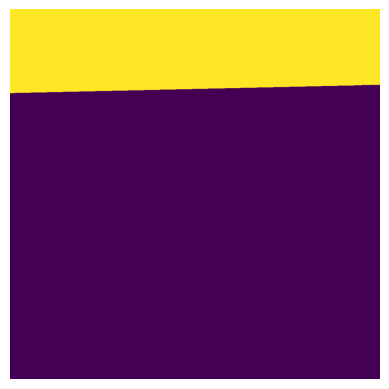

In [146]:
scene_black = scene_analysis_dict.black_mask.iloc[0]
plt.imshow(scene_black)
plt.axis('off')
plt.show()

In [147]:
scene_black.sum()/scene_black.size * 100

np.float64(21.613121032714844)

In [64]:
scene_polygon_gdf = scene_analysis_dict.polygons.iloc[0]
scene_polygon_gdf.loc[scene_polygon_gdf["id"] == 300, "area_px"].iloc[0]

np.float64(12674.0)

In [ ]:
scene_polygon_gdf.loc[scene_polygon_gdf["class_code"] == 9, "class_code"] = 10
scene_polygon_gdf

In [140]:
for i in range(400):
    row = analysis_df.iloc[i]
    if row["segmented"] == True:
        scene_polygon_path = row["polygon_path"]

        with open(f"{data_config["data_root"]}{data_config["xBD_analysed_path"]}{scene_polygon_path}", 'rb') as f:
            scene_analysis_dict = pickle.load(f)

        scene_black = scene_analysis_dict.black_mask.iloc[0]
        scene_unclassified = scene_analysis_dict.unclassified_mask.iloc[0]

        row["pct_black"] = scene_black.sum() / scene_black.size * 100
        row["pct_segmented"] = (1 - (scene_black.sum() + scene_unclassified.sum()) / scene_black.size) * 100

        analysis_df.iloc[i] = row


In [ ]:
analysis_df

In [141]:
tmp = MAIN_CSV_PATH + ".tmp"
analysis_df.to_csv(tmp, index=False, lineterminator="\n")
os.replace(tmp, MAIN_CSV_PATH)

In [114]:
scene_polygon_gdf = scene_polygon_gdf.sort_values("id").reset_index(drop=True)

In [117]:
scene_black = scene_analysis_dict.black_mask.iloc[0]
scene_black.size
scene_black.sum()

np.int64(55)

## Class Labelling

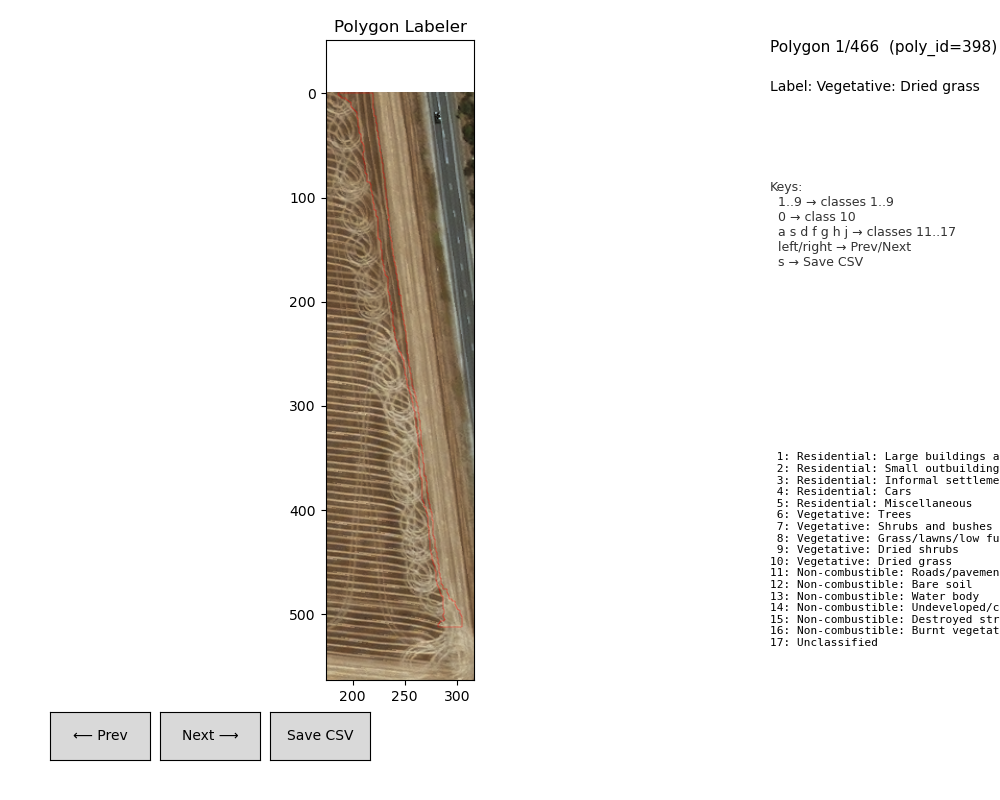

Ready. Loaded 466 polygons


In [ ]:
import math
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.widgets import Button

PAD_FRAC = 0.50                            # extra padding around polygon bbox when zooming

gdf = scene_polygon_gdf  # CRS is whatever your data uses

def get_current_image(row):
    return scene_norm_img

# --- Figure and axes ---
fig = plt.figure(figsize=(10, 8))
ax    = fig.add_axes([0.05, 0.15, 0.70, 0.80])
axbar = fig.add_axes([0.77, 0.15, 0.18, 0.80])  # info panel
axbar.axis("off")

# Buttons
ax_prev = fig.add_axes([0.05, 0.05, 0.10, 0.06])
ax_next = fig.add_axes([0.16, 0.05, 0.10, 0.06])
ax_save = fig.add_axes([0.27, 0.05, 0.10, 0.06])
btn_prev = Button(ax_prev, "⟵ Prev")
btn_next = Button(ax_next, "Next ⟶")
btn_save = Button(ax_save, "Save CSV")

state = {"i": 0,
         "pad_frac": 0.10
         }
img_artist = None
poly_artist = None

def set_label(poly_id, code):
    scene_polygon_gdf.loc[scene_polygon_gdf["id"] == poly_id, "class_code"] = code

def save_csv():
    axbar.text(0, -0.05, f"Saved", fontsize=9, color="green", transform=axbar.transAxes)
    fig.canvas.draw_idle()

def get_bbox_with_pad(xmin, ymin, xmax, ymax, pad_frac=PAD_FRAC):
    w = xmax - xmin
    h = ymax - ymin
    pad_x = max(1e-9, w * pad_frac)
    pad_y = max(1e-9, h * pad_frac)
    return xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y

def set_view_with_padding(ax, geom, pad_frac):
    xmin, ymin, xmax, ymax = geom.bounds
    w = xmax - xmin
    h = ymax - ymin
    px = max(1e-9, w * pad_frac)
    py = max(1e-9, h * pad_frac)
    ax.set_xlim(xmin - px, xmax + px)
    ax.set_ylim(ymin - py, ymax + py)

def render():
    global img_artist, poly_artist
    ax.clear()
    axbar.clear(); axbar.axis("off")

    # get current row
    row = gdf.iloc[state["i"]]
    geom = row.geometry
    poly_id = row["id"]

    # background image (optional)
    img = get_current_image(row)
    if img is not None:
        # assume image coordinate space matches polygon coordinates; if not, you’ll need a transform
        img_artist = ax.imshow(img, origin="upper")  # adjust origin if your coords differ
    else:
        img_artist = None
        ax.set_facecolor("#f2f2f2")

    # draw polygon(s) — handle MultiPolygon by iterating
    from shapely.geometry import Polygon, MultiPolygon
    def add_poly(g):
        if not isinstance(g, Polygon):
            return
        x, y = g.exterior.xy
        poly = MplPolygon(np.column_stack([x, y]), closed=True,
                          fill=False, edgecolor="red", linewidth=0.3, alpha=0.9)
        ax.add_patch(poly)
        return poly

    poly_artist = None
    if geom is not None and not geom.is_empty:
        if geom.geom_type == "Polygon":
            poly_artist = add_poly(geom)
            xmin, ymin, xmax, ymax = geom.bounds
        elif geom.geom_type == "MultiPolygon":
            xmin, ymin, xmax, ymax = geom.bounds
            for g in geom.geoms:
                add_poly(g)
        else:
            # For non-polygon geometries, plot their bounds
            xmin, ymin, xmax, ymax = geom.bounds
            ax.plot(*geom.envelope.exterior.xy, color="red", lw=2)

        # zoom to polygon bbox with padding
        xmin, xmax, ymin, ymax = *geom.bounds[:2], *geom.bounds[2:]
        # Correct tuple unpacking for clarity
        xmin, ymin, xmax, ymax = geom.bounds
        x0, x1, y0, y1 = get_bbox_with_pad(xmin, ymin, xmax, ymax, PAD_FRAC)
        ax.set_xlim(x0, x1)
        ax.set_ylim(y0, y1)

    set_view_with_padding(ax, geom, state["pad_frac"])

    # info panel
    code = scene_polygon_gdf.loc[scene_polygon_gdf["id"] == poly_id, "class_code"].iloc[0]
    name = CLASS_MAP.get(code, "Unlabeled")
    axbar.text(0, 1.0, f"Polygon {state['i']+1}/{len(gdf)}  (poly_id={poly_id})", fontsize=11, va="top")
    axbar.text(0, 0.92, f"Label: {name}", fontsize=10)

    # legend / shortcuts
    legend_lines = [
        "Keys:",
        "  1..9 → classes 1..9",
        "  0 → class 10",
        "  a s d f g h j → classes 11..17",
        "  left/right → Prev/Next",
        "  s → Save CSV",
    ]
    axbar.text(0, 0.78, "\n".join(legend_lines), fontsize=9, va="top", color="#333")

    # show class list
    class_text = "\n".join([f"{k:>2}: {v}" for k, v in CLASS_MAP.items()])
    axbar.text(0, 0.05, class_text, fontsize=8, va="bottom", family="monospace")

    ax.set_title("Polygon Labeler", fontsize=12)
    ax.invert_yaxis()         # make y increase upward
    ax.set_aspect('equal')
    ax.axis("on")
    fig.canvas.draw_idle()

def go(delta):
    state["i"] = int(np.clip(state["i"] + delta, 0, len(gdf) - 1))
    render()

def on_key(event):
    # navigation
    if event.key == "left":
        go(-1)
        return
    if event.key == "right":
        go(+1)
        return  
    if event.key in ("="):            # increase padding
        state["pad_frac"] = np.clip(state["pad_frac"] + 0.05, 0.0, 10)
        render()                            # re-draw current polygon with new padding
        return
    if event.key in ("-"):            # decrease padding
        state["pad_frac"] = np.clip(state["pad_frac"] - 0.05, 0.0, 10)
        render()
        return
    if event.key in ("]"):            # increase padding
        state["pad_frac"] = np.clip(state["pad_frac"] + 0.25, 0.0, 10)
        render()                            # re-draw current polygon with new padding
        return
    if event.key in ("["):            # decrease padding
        state["pad_frac"] = np.clip(state["pad_frac"] - 0.25, 0.0, 10)
        render()
        return
    if event.key.lower() == "r":
        row = gdf.iloc[state["i"]]
        set_view_with_padding(ax, row.geometry, state["pad_frac"])
        event.canvas.draw_idle()
        return
    # class shortcuts
    key = event.key.lower()
    poly_id = gdf.iloc[state["i"]]["id"]

    if key in list("123456789"):
        code = int(key)
        set_label(poly_id, code)
        render()
    elif key == "0":
        set_label(poly_id, 10); render()
    else:
        # map a..j to 11..17 using specific keys
        keymap = {"a":11, "s":12, "d":13, "f":14, "g":15, "h":16, "j":17}
        if key in keymap:
            set_label(poly_id, keymap[key]); render()

def on_close(evt):
    save_csv()

# wire buttons + events
btn_prev.on_clicked(lambda e: go(-1))
btn_next.on_clicked(lambda e: go(+1))
btn_save.on_clicked(lambda e: save_csv())
fig.canvas.mpl_connect("key_press_event", on_key)
fig.canvas.mpl_connect("close_event", on_close)

render()
plt.show()

print(f"Ready. Loaded {len(gdf)} polygons")


In [ ]:
scene_polygon_gdf

In [58]:
with open(f"{data_config["data_root"]}{data_config["xBD_analysed_path"]}{scene_polygon_path}", "wb") as f:
	pickle.dump(scene_analysis_dict, f)

In [68]:
scene_polygon_gdf.rename(columns={"class": "class_code"}, inplace=True)

## Class Mapping

In [84]:
import numpy as np
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.enums import MergeAlg

# gdf has columns: geometry (polygons), class (1..17)
# image size
H, W = scene_norm_img.shape[:2]

# Sort so **low priority first, high priority last** (17 .. 1)
gdf_sorted = scene_polygon_gdf.sort_values("class_code", ascending=False)

# Start filled with 17 (your “remainder” class)
class_map = np.full((H, W), 17, dtype=np.uint8)

# Burn in order; later shapes overwrite earlier ones
shapes = [(geom, int(cls)) for geom, cls in zip(gdf_sorted.geometry, gdf_sorted.class_code)]

burned = rasterize(
    shapes=shapes,
    out_shape=(H, W),
    transform=Affine.identity(),  # adjust if your coords differ
    fill=17,                     # any untouched pixel stays 17
    dtype="uint8",
    all_touched=False,           # True = more inclusive edges; tune per need
    merge_alg=MergeAlg.replace   # later geometries replace earlier values
)

class_map[:] = burned


In [91]:
post_label_f = f"{data_config["data_root"]}{data_config["xBD_analysed_path"]}{scene_polygon_path}"
post_label_f

"/Users/abdullah/OneDrive - King's College London/Datasets/WUI_Imagery/xBD_Dataset/Analysed_Images/pinery_0032_polygons.pkl"

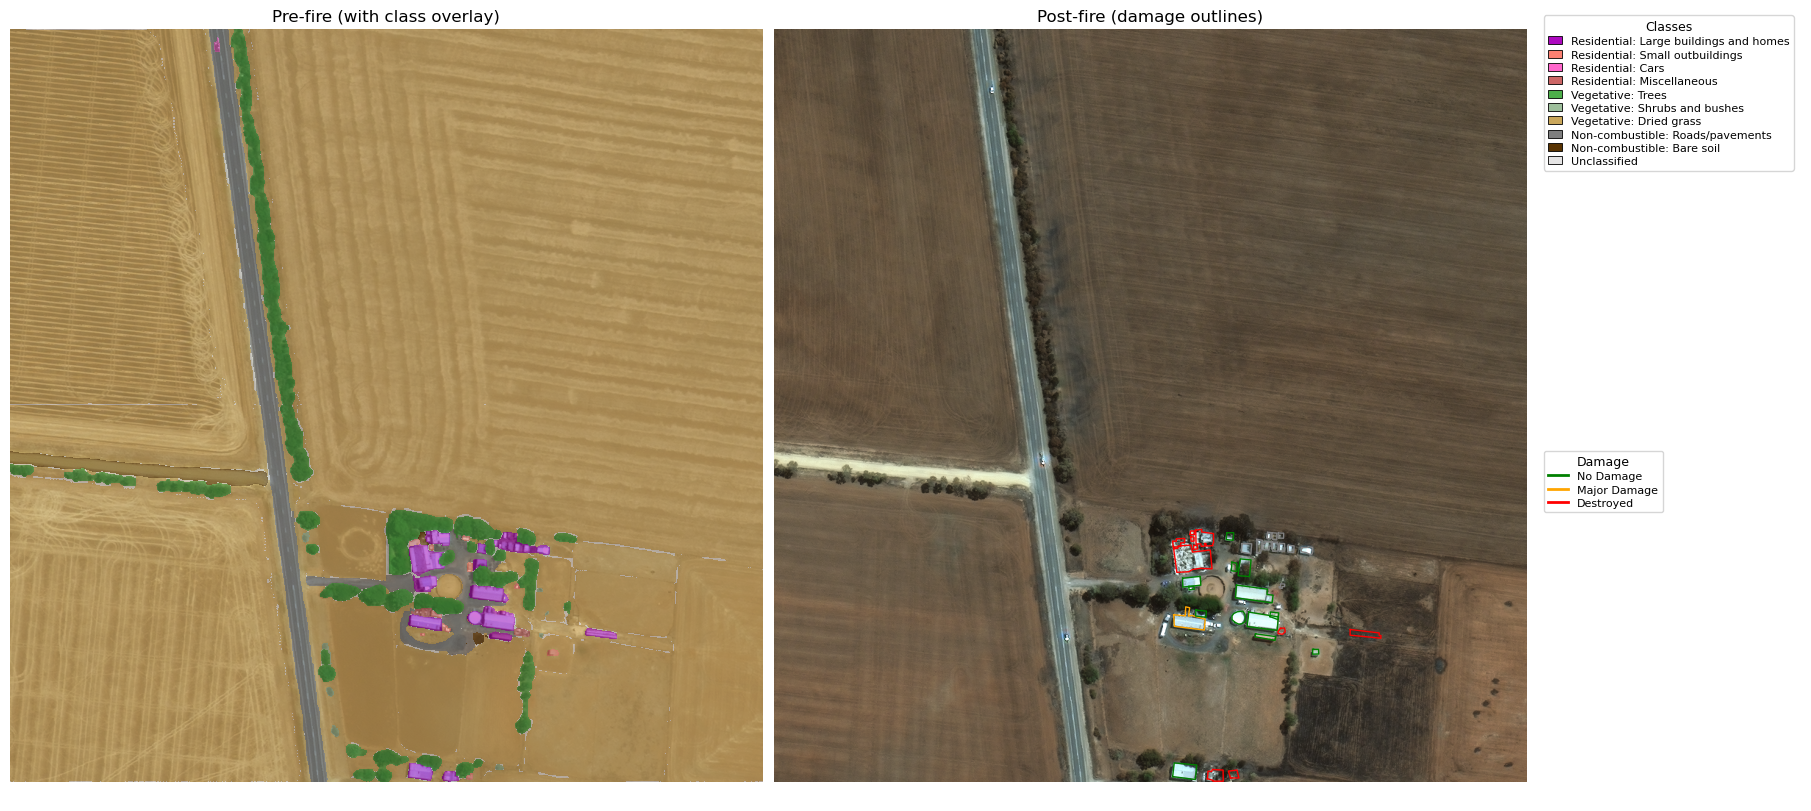

In [104]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np
import json, rasterio
from shapely import wkt

# ----- colormap (0..17) -----
colors = [
    "#00000000",  # 0 transparent
    "#ad09bf", "#fb8072", "#cc0033", "#ff66cc", "#cc6666",   # 1..5
    "#4daf4a", "#9ebf9c", "#a8e33b", "#8c6d1f", "#caa75b",   # 6..10
    "#7f7f7f", "#583302", "#4aa3ff", "#aaaaaa", "#7f0000",   # 11..15
    "#122712", "#E6E5E5"                                     # 16..17
]
cmap = ListedColormap(colors)
# bins centered on 0..17 (exactly 18 bins, no spare)
norm = BoundaryNorm(np.arange(0, 18) - 0.5, cmap.N)

# ----- damage legend colors -----
damage_colors = {
    "no-damage": "green",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red",
}

# ----- figure layout: 2 big axes + 1 skinny legend axis -----
fig = plt.figure(figsize=(18, 8), constrained_layout=True)
gs  = GridSpec(1, 3, width_ratios=[1, 1, 0.35], figure=fig)

ax0 = fig.add_subplot(gs[0, 0])  # pre + class overlay
ax1 = fig.add_subplot(gs[0, 1])  # post + damage outlines
axL = fig.add_subplot(gs[0, 2])  # legend panel
axL.axis("off")

# ----- PRE image + class overlay -----
ax0.imshow(scene_norm_img, origin="upper")
ax0.imshow(class_map, origin="upper", cmap=cmap, norm=norm,
           alpha=0.55, interpolation="nearest")
ax0.set_aspect("equal")
ax0.set_title("Pre-fire (with class overlay)", fontsize=12)
ax0.set_axis_off()

# ----- Build class legend handles for PRESENT classes only -----
present = np.unique(class_map)
present = present[present != 0]    # skip background
# map present class ids to handles
handles_classes = [
    Patch(facecolor=cmap(norm(int(c))), edgecolor='k',
          label=CLASS_MAP[int(c)], linewidth=0.6)
    for c in np.sort(present)
]
# make legend patches opaque (overlay alpha doesn’t affect legend)
for h in handles_classes:
    h.set_alpha(1.0)

# ----- POST image + damage overlays -----
# (fix f-strings quoting)
post_label_path = scene_info["post_label_path"]
post_label_f = f"{data_config['data_root']}{data_config['xBD_images_path']}{post_label_path}"

post_image_path = scene_info["post_image_path"]
post_image_f = f"{data_config['data_root']}{data_config['xBD_images_path']}{post_image_path}"

with rasterio.open(post_image_f) as src:
    post_image_data = src.read([1, 2, 3]).transpose(1, 2, 0)

with open(post_label_f, 'r') as f:
    post_label_data = json.load(f)

ax1.imshow(post_image_data, origin="upper")
for feature in post_label_data['features']['xy']:
    damage_level = feature['properties'].get('subtype', 'no-damage')
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    color = damage_colors.get(damage_level, 'gray')
    ax1.plot(x, y, color=color, linewidth=1)
ax1.set_aspect("equal")
ax1.set_title("Post-fire (damage outlines)", fontsize=12)
ax1.set_axis_off()

# ----- damage legend handles (only those present) -----
present_damage = set(
    feature['properties'].get('subtype', 'no-damage')
    for feature in post_label_data['features']['xy']
)
handles_damage = [
    Line2D([0], [0], color=damage_colors[k], lw=2, label=k.replace("-", " ").title())
    for k in damage_colors.keys() if k in present_damage
]

# ----- compose legends in side panel -----
# First the class legend (can be multi-column if many)
leg1 = axL.legend(handles=handles_classes, loc="upper left",
                  title="Classes", frameon=True,
                  fontsize=8, title_fontsize=9,
                  borderpad=0.4, labelspacing=0.3, handlelength=1.2,
                  ncol=1)  # set ncol=2 if long
axL.add_artist(leg1)  # keep it when adding a second legend

# Then the damage legend below it
leg2 = axL.legend(handles=handles_damage, loc="upper left",
                  bbox_to_anchor=(0.0, 0.45),  # push it down a bit
                  title="Damage", frameon=True,
                  fontsize=8, title_fontsize=9,
                  borderpad=0.4, labelspacing=0.3, handlelength=1.8)

plt.show()


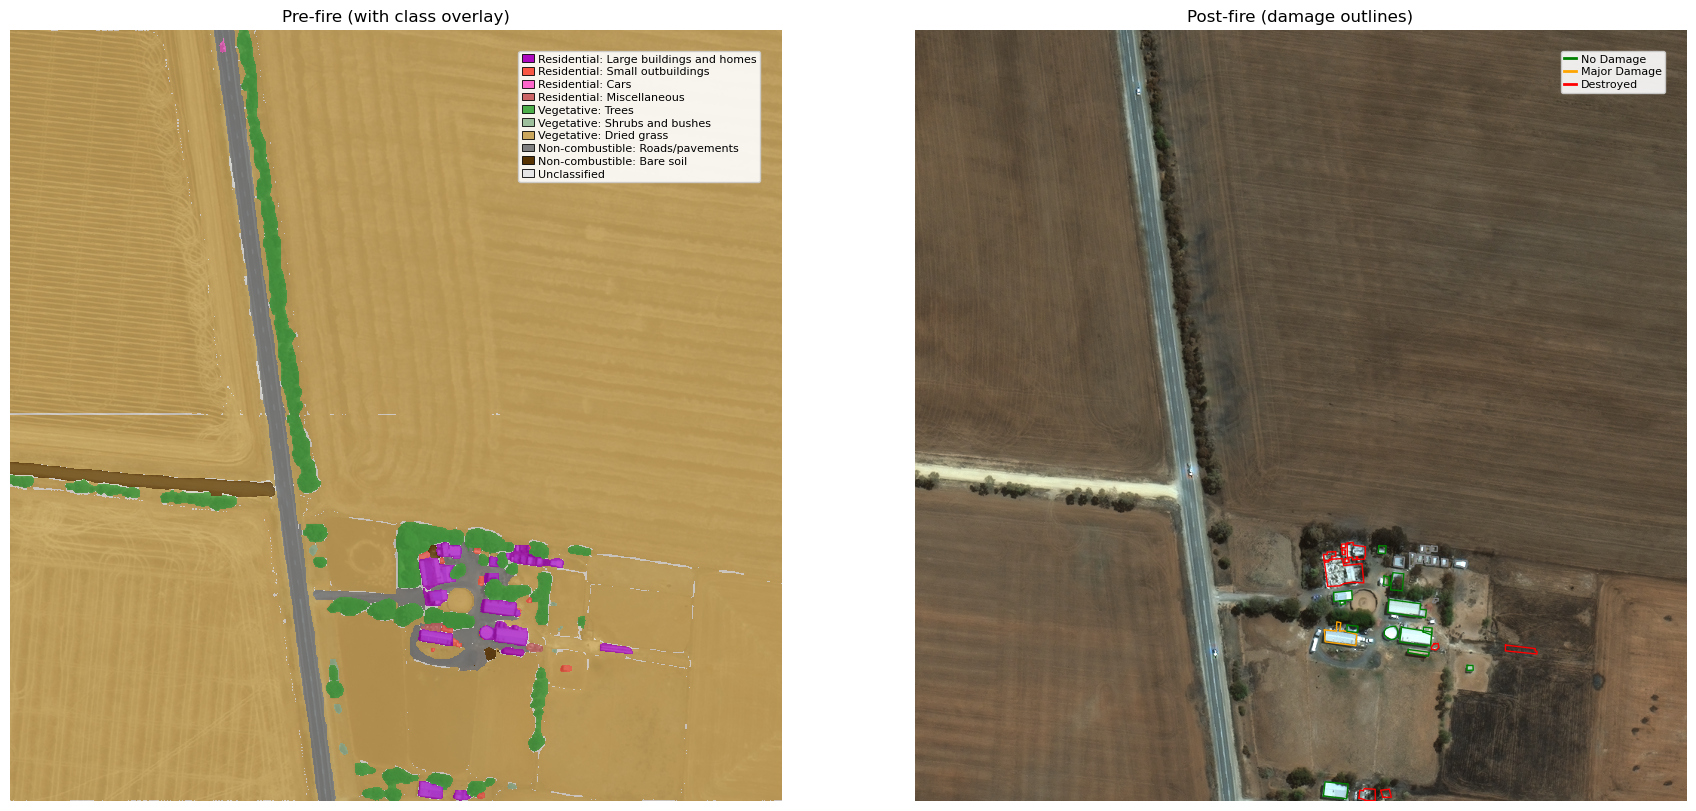

In [109]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# ===== consistent legend sizing =====
LEG_FONTSIZE = 8
LEG_TITLE_FONTSIZE = 9
LEG_KW = dict(
    fontsize=LEG_FONTSIZE, title_fontsize=LEG_TITLE_FONTSIZE,
    frameon=True, framealpha=0.9,
    borderpad=0.3, labelspacing=0.25, handlelength=1.1, handletextpad=0.4,
    columnspacing=0.8, ncol=1
)

# ===== colormap (0..17) =====
colors = [
    "#00000000",  # 0 transparent
    "#ad09bf", "#fa5644", "#cc0033", "#ff66cc", "#cc6666",   # 1..5
    "#4daf4a", "#9ebf9c", "#a8e33b", "#8c6d1f", "#caa75b",   # 6..10
    "#7f7f7f", "#583302", "#4aa3ff", "#aaaaaa", "#7f0000",   # 11..15
    "#122712", "#E6E5E5"                                     # 16..17
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(0, 18) - 0.5, cmap.N)  # bins for 0..17

# ===== figure =====
fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)

# -- LEFT: pre + class overlay --
ax0 = axes[0]
ax0.imshow(scene_norm_img, origin="upper")
ax0.imshow(class_map, origin="upper", cmap=cmap, norm=norm, alpha=0.75, interpolation="nearest")
ax0.set_aspect("equal"); ax0.set_axis_off()
ax0.set_title("Pre-fire (with class overlay)", fontsize=12)

# class legend (only present classes)
present = np.unique(class_map)
present = present[present != 0]  # skip 0/background
handles_classes = [
    Patch(facecolor=cmap(norm(int(c))), edgecolor='k', linewidth=0.6, label=CLASS_MAP[int(c)])
    for c in np.sort(present)
]
for h in handles_classes:  # make legend swatches opaque
    h.set_alpha(1.0)

# Place inside top-right corner (same size as the right legend)
leg0 = ax0.legend(
    handles=handles_classes,
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),  # nudge off the edges a touch
    **LEG_KW
)

# -- RIGHT: post + damage overlays --
ax1 = axes[1]
ax1.imshow(post_image_data, origin="upper")
for feature in post_label_data['features']['xy']:
    damage_level = feature['properties'].get('subtype', 'no-damage')
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    color = {"no-damage": "green", "minor-damage": "yellow",
             "major-damage": "orange", "destroyed": "red"}.get(damage_level, "gray")
    ax1.plot(x, y, color=color, linewidth=1)

ax1.set_aspect("equal"); ax1.set_axis_off()
ax1.set_title("Post-fire (damage outlines)", fontsize=12)

# damage legend (only present damage types)
present_damage = set(
    feature['properties'].get('subtype', 'no-damage')
    for feature in post_label_data['features']['xy']
)
damage_colors = {"no-damage": "green", "minor-damage": "yellow",
                 "major-damage": "orange", "destroyed": "red"}
handles_damage = [
    Line2D([0], [0], color=damage_colors[k], lw=2, label=k.replace("-", " ").title())
    for k in damage_colors if k in present_damage
]

leg1 = ax1.legend(
    handles=handles_damage,
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),  # mirror placement/sizing
    **LEG_KW
)

plt.savefig("./Figures/xBD_Classification.png", dpi=300, bbox_inches="tight")
plt.show()


In [111]:
total = scene_norm_img.shape[0] * scene_norm_img.shape[1]
unclassified = class_map == 17
pct_any = 100.0 * unclassified.sum() / total
print(f"Unclassified: {pct_any:.2f}%")

Unclassified: 0.62%
